<a href="https://colab.research.google.com/github/NBK-code/Time_Series_Data/blob/main/Using_XGBoost_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

##Load Data

In [84]:
df = pd.read_csv('/content/PJME_hourly.csv')

In [85]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [86]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


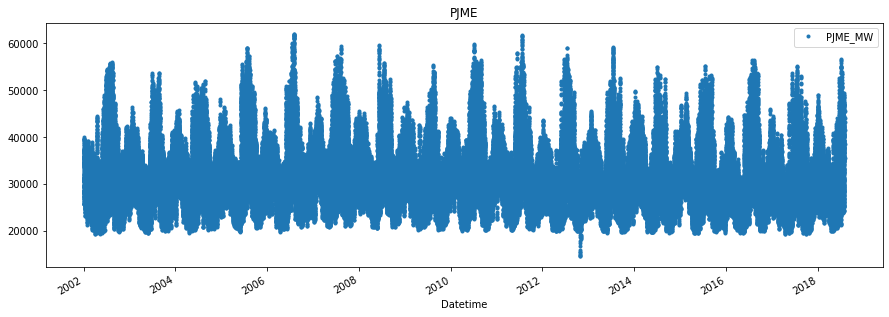

In [87]:
df.plot(style = '.', figsize = (15,5), title = 'PJME')
plt.show()

##Outliers

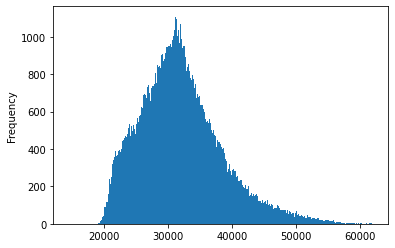

In [88]:
df['PJME_MW'].plot(kind = 'hist', bins = 500)

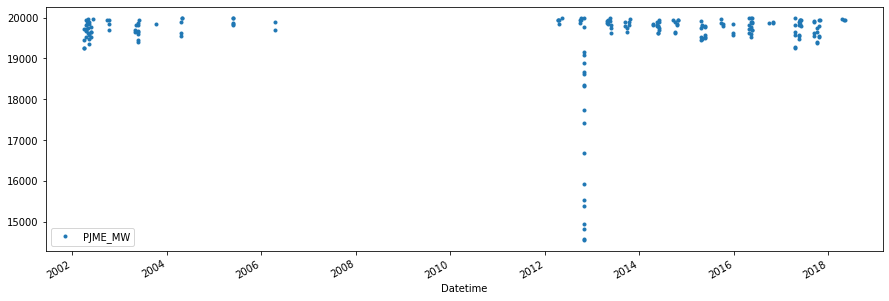

In [89]:
df.loc[df['PJME_MW'] < 20000].plot(figsize = (15,5), style = '.')

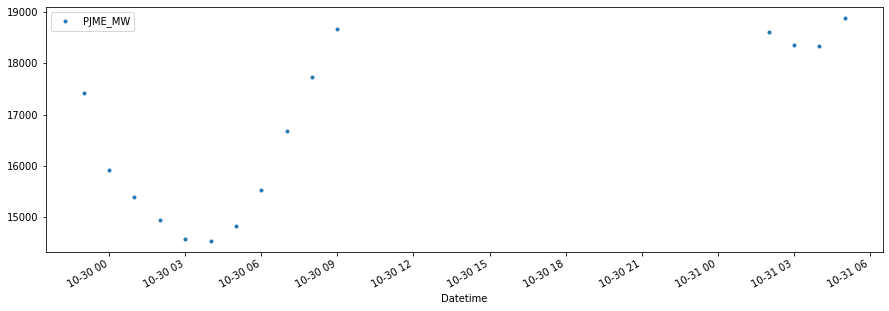

In [90]:
df.loc[df['PJME_MW'] < 19_000].plot(figsize = (15,5), style = '.')

19_000 is a better threshold.

We will use winsoring to deal with the outliers. For all the PJME_MW values < 19,000, we will set their values to be equal to 19,000.

In [91]:
df.loc[df['PJME_MW'] < 19_000, 'PJME_MW'] = 19_000

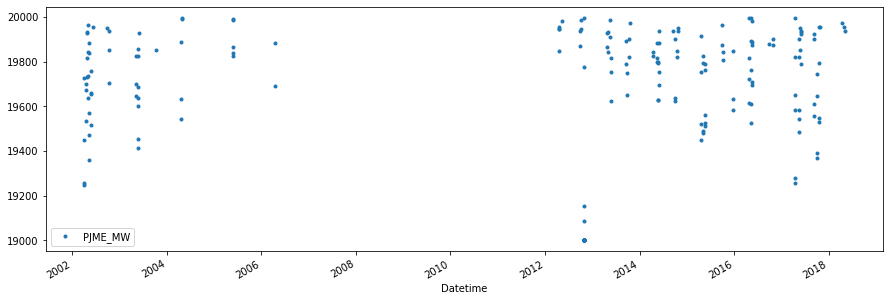

In [92]:
df.loc[df['PJME_MW'] < 20000].plot(figsize = (15,5), style = '.')

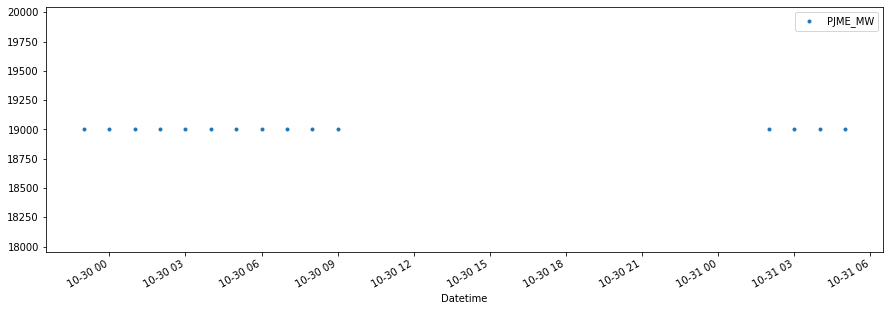

In [93]:
df.loc[df['PJME_MW'] <= 19_000].plot(figsize = (15,5), style = '.')

## Time Series Cross validation

In [94]:
from sklearn.model_selection import TimeSeriesSplit

In [95]:
#Time series split object is a generator
tss = TimeSeriesSplit(n_splits = 5, test_size = 24*365*1, gap = 24)
#gap is the gap between the train and test set
df = df.sort_index()
#If the dataframe index is not sorted the time series split will not work

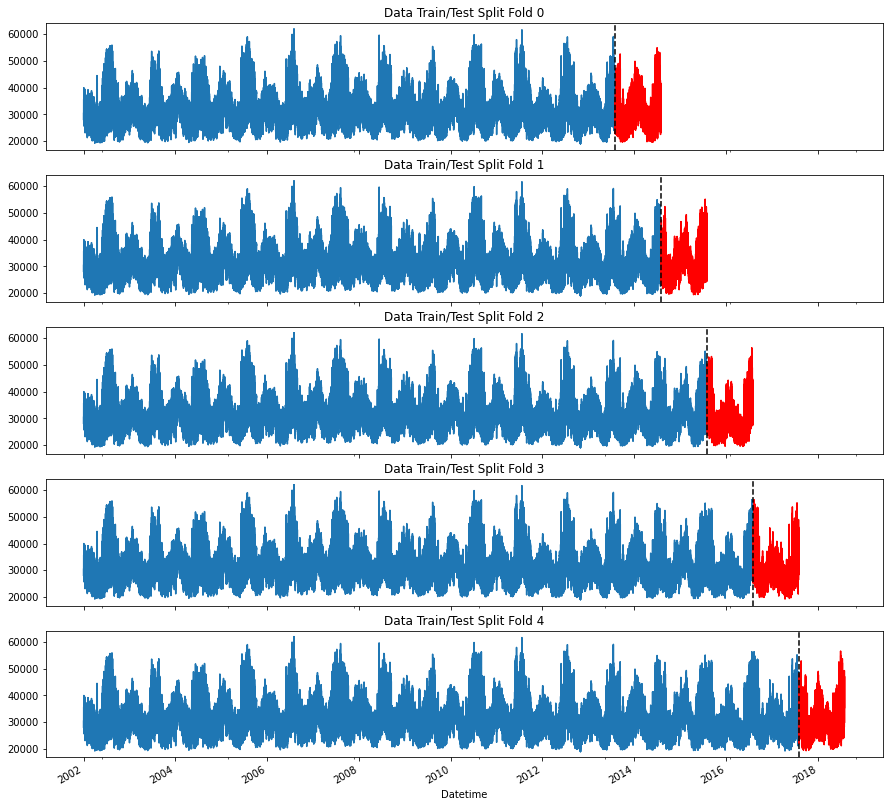

In [96]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set',
                         color = 'red')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

##Forecasting Horizon

Forecasting horizon is the how farther out are we going to predict.

We are also restricted by the lag features.

In [97]:
def create_features(df):
  df = df.copy()
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear

  return df

In [98]:
df = create_features(df)

In [99]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1


##Lag Features

In [100]:
target_map = df['PJME_MW'].to_dict()

In [101]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()

    #Lag can't be greater than the forecasting horizon
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [102]:
df = add_lags(df)

In [103]:
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,33539.0,32094.0,31695.0


##Train Using Cross validation

In [106]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear','hour','dayofweek','quarter','month','year','lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=2000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[11:17:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32730.8	validation_1-rmse:31956.7
[100]	validation_0-rmse:12531.9	validation_1-rmse:11909.1
[200]	validation_0-rmse:5740.63	validation_1-rmse:5354.42
[300]	validation_0-rmse:3867.86	validation_1-rmse:3895.4
[400]	validation_0-rmse:3430.18	validation_1-rmse:3757.21
[500]	validation_0-rmse:3313.84	validation_1-rmse:3771.12
[600]	validation_0-rmse:3257.93	validation_1-rmse:3784.41
[700]	validation_0-rmse:3217.79	validation_1-rmse:3791.65
[800]	validation_0-rmse:3183.32	validation_1-rmse:3803.78
[900]	validation_0-rmse:3153.66	validation_1-rmse:3789.45
[1000]	validation_0-rmse:3122.16	validation_1-rmse:3780.88
[1100]	validation_0-rmse:3092.78	validation_1-rmse:3781.32
[1200]	validation_0-rmse:3065.92	validation_1-rmse:3773.09
[1300]	validation_0-rmse:3041.46	validation_1-rmse:3762.19
[1400]	validation_0-rmse:3022.73	validation_1-rmse:3760.61
[

In [107]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3782.6298
Fold scores:[3761.014345797648, 3377.298218239057, 3787.1465574426697, 3978.1567005677475, 4009.532960992251]


When hyperparameter tune, we would like our score (rmse) to decrease for all the 5 folds. 

##Predicting the Future
1. Retraining on all data
2. To Predict the future we need an emtpy dataframe for future date ranges.
3. Run those dates through our feature creation code + lag creation

In [108]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear','hour','dayofweek','quarter','month','year','lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=1000,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=100)


[11:34:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32402.7
[100]	validation_0-rmse:12426.2
[200]	validation_0-rmse:5752.11
[300]	validation_0-rmse:3970.2
[400]	validation_0-rmse:3570.09
[500]	validation_0-rmse:3455.16
[600]	validation_0-rmse:3401.53
[700]	validation_0-rmse:3365.09
[800]	validation_0-rmse:3337.27
[900]	validation_0-rmse:3312.7
[999]	validation_0-rmse:3288.93


XGBRegressor(learning_rate=0.01, n_estimators=1000)

In [109]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [110]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [111]:
df_and_future.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3,isFuture
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,40666.0,34555.0,34641.0,True
2019-08-01 00:00:00,NaN,0,3,3,8,2019,213,37158.0,31646.0,31470.0,True


In [112]:
future_w_features = df_and_future.query('isFuture').copy()

In [113]:
future_w_features[FEATURES]

,dayofyear,hour,dayofweek,quarter,month,year,lag1,lag2,lag3
2018-08-03 00:00:00,215,0,4,3,8,2018,33539.0,32094.0,31695.0
2018-08-03 01:00:00,215,1,4,3,8,2018,30781.0,29503.0,29128.0
2018-08-03 02:00:00,215,2,4,3,8,2018,29015.0,27712.0,27373.0
2018-08-03 03:00:00,215,3,4,3,8,2018,27884.0,26535.0,26233.0
2018-08-03 04:00:00,215,4,4,3,8,2018,27223.0,25870.0,25643.0
...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,212,20,2,3,7,2019,46912.0,39352.0,40243.0
2019-07-31 21:00:00,212,21,2,3,7,2019,45985.0,38699.0,39183.0
2019-07-31 22:00:00,212,22,2,3,7,2019,44094.0,37346.0,37759.0
2019-07-31 23:00:00,212,23,2,3,7,2019,40666.0,34555.0,34641.0


In [114]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

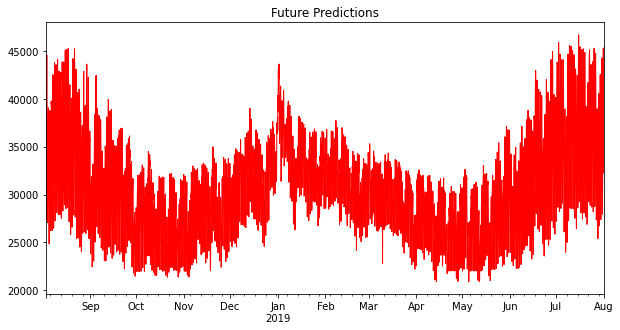

In [115]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color='red',
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

##Save Model

In [116]:
# Save model
reg.save_model('model.json')

In [117]:
!ls -lh

total 4.6M
-rw-r--r-- 1 root root 675K Nov 13 11:42 model.json
-rw-r--r-- 1 root root 3.9M Nov 13 09:28 PJME_hourly.csv
drwxr-xr-x 1 root root 4.0K Nov 10 14:30 sample_data


In [119]:
#Load Model
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')

[11:44:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


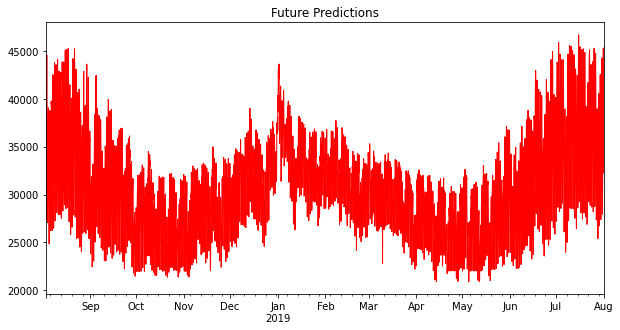

In [120]:
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color='red',
                               ms=1, lw=1,
                               title='Future Predictions')